In [1]:
# default import, might be useless

# deep learning library
import torch
import torchvision
from   torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# to import data
import torchvision.transforms as transforms 
import torchvision.datasets.mnist as mnist  

# we use torch.cuda.Event(enable_timing=True) to measure time
# if you don't have cuda, you can use instead :
# from timeit import default_timer as timer
# import time

import collections           # for ordered_dictionnary
import torch.nn.init as init # to initialize model

import copy # for copy.deepcopy( ... )

import numpy as np

# to make and display plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 

# to format time to strings
import datetime                      

import math # for ceil ()

import IPython.display # to display .png

import time
import collections
import os
import sys
import torch
import torch.nn
from torch.autograd import Variable
import torch.nn as nn

from torch.distributions.normal import Normal
from torchvision.utils import *

import torch
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import dataset
from torch import nn
# from torch.nn.modules import upsampling
# from torch.functional import F
from torch.optim import Adam

In [2]:
# Use the GPU if you have one
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device("cuda") 
else:
    print("WARNING: You are about to run on cpu")
    device = torch.device("cpu")


Using the GPU


In [3]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5),
                         (.5, .5, .5))
])


def get_data_loader(dataset_location, batch_size):
    trainvalid = torchvision.datasets.SVHN(
        dataset_location, split='train',
        download=True,
        transform=image_transform
    )

    trainset_size = int(len(trainvalid) * 0.9)
    trainset, validset = dataset.random_split(
        trainvalid,
        [trainset_size, len(trainvalid) - trainset_size]
    )

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    validloader = torch.utils.data.DataLoader(
        validset,
        batch_size=batch_size,
    )

    testloader = torch.utils.data.DataLoader(
        torchvision.datasets.SVHN(
            dataset_location, split='test',
            download=True,
            transform=image_transform
        ),
        batch_size=batch_size,
    )

    return trainloader, validloader, testloader

In [4]:
# sets are called train, valid, test
batch_size = 64
trainset, validset, testset = get_data_loader("svhn", batch_size)

Using downloaded and verified file: svhn\train_32x32.mat
Using downloaded and verified file: svhn\test_32x32.mat


In [5]:
# define decoder (generator) and critics (without batchnorm, with no sigmoid)

class UnFlatten(nn.Module):
    def __init__(self, n_channel=16, p_size=8 ):
        super(UnFlatten, self).__init__()
        self.n_channel = n_channel
        self.p_size    = p_size
        
    def forward(self, input):
        return input.view(input.size(0), self.n_channel, self.p_size, self.p_size).contiguous()

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, input):
        return input.view(input.size(0), -1).contiguous()


def make_openai_critic(ndf1, ndf2, ndf3, ndf4, drop_p=0.5):
    critic = nn.Sequential(
        # bs : batch size 
        
        # input is bs x (3) x 32 x 32
        nn.utils.weight_norm(nn.Conv2d(3, ndf1, 3, stride=1, padding=1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        # state size. bs x (ndf1) x 32 x 32
        nn.utils.weight_norm(nn.Conv2d(ndf1, ndf1, 3, 1, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        # state size. bs x (ndf1) x 32 x 32
        nn.utils.weight_norm(nn.Conv2d(ndf1, ndf2, 3, 1, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        torch.nn.MaxPool2d(2),
        
        nn.Dropout(drop_p),
        
        # input is    bs x (ndf2) x 16 x 16
        nn.utils.weight_norm(nn.Conv2d(ndf2, ndf2, 3, stride=1, padding=1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        # state size. bs x (ndf3) x 16 x 16
        nn.utils.weight_norm(nn.Conv2d(ndf2, ndf2, 3, 1, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        # state size. bs x (ndf2) x 16 x 16
        nn.utils.weight_norm(nn.Conv2d(ndf2, ndf3, 3, 1, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        torch.nn.MaxPool2d(2),
        
        nn.Dropout(drop_p),
        
        # state size. bs x (ndf3) x 8 x 8
        nn.utils.weight_norm(nn.Conv2d(ndf3, ndf3, 3, 1, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        torch.nn.MaxPool2d(2),
        # state size. bs x (ndf3) x 4 x 4
        nn.utils.weight_norm(nn.Conv2d(ndf3, ndf3, 3, 1, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        torch.nn.MaxPool2d(2),
        # state size. bs x (ndf3) x 2 x 2
        nn.utils.weight_norm(nn.Conv2d(ndf3, ndf4, 3, 1, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        
        Flatten(),
        # state size. bs x (ndf4x2x2)
        nn.utils.weight_norm( nn.Linear(ndf4*2*2, 1) ),
        # state size. bs x (1)
        )
    return critic
    
def make_GAN_decoder(z_dim=100,ngf=64,nc=3):
    decoder = nn.Sequential(
            # input is Z, going into a convolution
            UnFlatten(z_dim,1),
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.Conv2d( ngf, nc, 5, stride=1, padding=2, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )
    return decoder

def make_GAN_critic(ndf=64,nc=3):
    decoder = nn.Sequential(
        # bs : batch size 
        # input is bs x (nc) x 32 x 32
        nn.Conv2d(nc, ndf, 5, stride=1, padding=2, bias=False),
        nn.ReLU(inplace=True),
        # state size. bs x (ndf) x 32 x 32
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.ReLU(inplace=True),
        # state size. bs x (ndf*2) x 16 x 16
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.ReLU(inplace=True),
        # state size. bs x (ndf*4) x 8 x 8
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.ELU(inplace=True),
        # state size. bs x (ndf*8) x 4 x 4
        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        # state size. bs x (1) x 1 x 1
        )
    return decoder

class MLP(nn.Module):
    """
    This is just an MLP with 1 hidden layer
    """
    def __init__(self, in_size, h_size, out_size, dropout=0.1):
        super(MLP, self).__init__()
        self.w_1 = nn.Linear(in_size, h_size  )
        self.w_2 = nn.Linear(h_size , out_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
def make_GAN_critic_B(ndf=128,drop_p=0.25):
    decoder = nn.Sequential(
        # bs : batch size 
        
        # input is bs x (nc) x 32 x 32
        nn.utils.weight_norm(nn.Conv2d(3, ndf, 5, stride=1, padding=2, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Dropout(drop_p),
        # state size. bs x (ndf) x 32 x 32
        nn.utils.weight_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Dropout(drop_p),
        # state size. bs x (ndf*2) x 16 x 16
        nn.utils.weight_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Dropout(drop_p),
        # state size. bs x (ndf*4) x 8 x 8
        nn.utils.weight_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
        nn.Dropout(drop_p),
        # state size. bs x (ndf*8) x 4 x 4
        )
    return decoder

In [6]:
def number_of_params( net ) :
    nb_param  = 0
    depth     = 0 # count the number of different bias
    param_lst = " "
    for i, (key, value) in enumerate( net.state_dict().items() ) :
        if key.endswith("bias") :
            depth = depth + 1            
        nb_param_tmp = 1        
        for j , x in enumerate(value.size()) :               
            nb_param_tmp = nb_param_tmp * x                
        nb_param = nb_param + nb_param_tmp     
    return nb_param, depth

In [7]:
# the model :
# model = make_GAN_decoder(z_dim=100,ngf=128,nc=3)
model = make_GAN_critic_B(ndf=128)
nparam, _ = number_of_params(model)
print(nparam)

11021568


In [8]:
# custom weights from DCGAN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [9]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, ngf=128 ):
        super(Generator, self).__init__()
        self.main = make_GAN_decoder(z_dim,ngf)
        self.init()
        
    def init(self):
        self.apply(weights_init)
        
    def forward(self, input):
        return self.main(input)

class Critic(nn.Module):
    def __init__(self, ndf=128,drop_p=0.1):
        super(Critic, self).__init__()
        # self.main = make_GAN_critic(ndf) <-- save 4
        
        self.main   = make_GAN_critic_B(ndf,drop_p) # <-- save  
        self.critic = nn.utils.weight_norm(nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False))
        self.classifier = MLP( (ndf*8) * 4 * 4 , 256, 10, drop_p )
        
        # self.main = make_openai_critic(64, 128, 256, 512, 0.5)
        self.init()
        
    def init(self):
        self.apply(weights_init)
        
    def forward(self, input):
        output = self.main(input)
        # state size. bs x (ndf*8) x 4 x 4
        
        critic = self.critic(output).view(-1, 1).squeeze(1)
        # state size. bs x (1) x 1 x 1
            
        classl = self.classifier(output.view(input.size(0), -1)) # classify input
        
        return critic, classl
    
    def calc_gradient_penalty(self, bs, real_data, fake_data):
        # print "real_data: ", real_data.size(), fake_data.size()
        alpha = torch.rand(bs, 1, device=device)
        alpha = alpha.expand(bs, 3*32*32 ).contiguous().view(bs, 3, 32, 32)

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)
        interpolates = interpolates.requires_grad_()

        disc_interpolates,_ = self.forward(interpolates)

        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size(),device=device),
                                  create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradients = gradients.view(gradients.size(0), -1)

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

In [10]:
# sets are called train, valid, test
batch_size = 32
trainset, validset, testset = get_data_loader("svhn", batch_size)

Using downloaded and verified file: svhn\train_32x32.mat
Using downloaded and verified file: svhn\test_32x32.mat


In [11]:
# define models :
netD = Critic().to(device)
netG = Generator().to(device)

In [12]:
z,i = netD( torch.empty(10,3,32,32,device=device) )
print( z.shape )
print( i.shape )

torch.Size([10])
torch.Size([10, 10])


In [38]:
want_save = True
# want_save = False
if want_save :
    save_dir = "GAN_save/samples/old_9/"
    torch.save(netG.state_dict(), save_dir + 'netG_checkpoint.pt')
    torch.save(netD.state_dict(), save_dir + 'netD_checkpoint.pt')

In [25]:
want_load = True
# want_load = False
if want_load :
    load_dir   = "GAN_save/samples/old_4/"
    fn_D       = "netD_checkpoint.pt"
    fn_G       = "netG_checkpoint.pt"
    PATH_D     = load_dir + fn_D
    PATH_G     = load_dir + fn_G
    netD.load_state_dict(torch.load(PATH_D))
    netG.load_state_dict(torch.load(PATH_G))

In [36]:
paramD = netD.parameters()
paramG = netG.parameters()
optimizerD = optim.Adam(paramD, lr=1*1e-4, betas=(0.5, 0.999), weight_decay=1e-5, amsgrad=True) 
optimizerG = optim.Adam(paramG, lr=1*1e-4, betas=(0.5, 0.999), weight_decay=1e-5, amsgrad=True)
# optimizerD = optim.Adam(paramD, lr=1*1e-4) 
# optimizerG = optim.Adam(paramG, lr=1*1e-4)

In [37]:
want_log     = False
want_samples = True
save_dir     = "GAN_save/samples/"

classification_loss = nn.CrossEntropyLoss()
ALPHA  = 0 # ponderation of classification loss in the critics network

# hyperparam :
LAMBDA = 10
EPOCHS = 10
CRITIC_ITERS = 5    # How many critic iterations per generator iteration
OUTPUT_DIM   = 3072 # Number of pixels in SVHN (3*32*32)
BATCH_SIZE   = batch_size
DIM          = 100  # latent dimension

# fixed noise to show progress of generator
fixed_noise_32 = torch.randn(32, DIM,device=device)

start_time = time.time()
for epoch in range(EPOCHS):
    print("epoch : {e}, time spent since start : {t}".format( e=epoch, t=time.time()-start_time ) )
    netG.train()
    netD.train()
    lossClass = 0
    lossD     = 0
    gp_loss   = 0
    for batch_idx_in_epoch, (real_data, labels) in enumerate(trainset):
        if batch_idx_in_epoch % 50 == 49 :
            print("progress : {p}%".format(p=batch_idx_in_epoch*100//len(trainset)))
            print("avg critic loss : {cl} \n avg grad loss : {gl} \n avg classification loss : {cll}".format( 
                cl = lossD/batch_idx_in_epoch,
                gl = gp_loss/batch_idx_in_epoch,
                cll= lossClass/batch_idx_in_epoch
                    )
                )
            if want_samples : 
                with torch.no_grad():
                    file_samples = save_dir + "{date:%H%M%S}.jpg".format( date=datetime.datetime.now() )
                    gen_from_fixed_noise = netG(fixed_noise_32)
                    grid_img = torchvision.utils.save_image(gen_from_fixed_noise.cpu(), file_samples, nrow=8, normalize=True)
                
        if real_data.size(0) != BATCH_SIZE: # if necessary, skip the last batch
            continue 
        
        # index of current batch from the beginning of training
        batch_idx = epoch * len(trainset) + batch_idx_in_epoch
        
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()

        real_data = real_data.to(device)
        labels    = labels.to(device)
        
        # train with real
        r_output,labels_  = netD(real_data)
        errD_real = r_output.mean()
        D_x       = errD_real.item()

        c_loss = classification_loss(labels_, labels)
        lossClass += c_loss.item()
        
        # train with fake
        noise = torch.randn(BATCH_SIZE, DIM, device=device)
        with torch.no_grad():
            fake = netG(noise)
        f_output,_ = netD(fake.detach())
        errD_fake  = f_output.mean()
        D_G_z1     = errD_fake.item()
        
        # train with gradient penalty
        gradient_penalty = LAMBDA * netD.calc_gradient_penalty(BATCH_SIZE, real_data.data, fake.data)
        gp_loss += gradient_penalty.item()
        
        # print("gradien_penalty: ", gradient_penalty)

        D_cost = errD_fake - errD_real + gradient_penalty + ALPHA * c_loss
        D_cost.backward()
        optimizerD.step()
        
        lossD += D_cost.item()
        # Wasserstein_D = D_x - D_G_z1
        # plot('./train disc cost'     , D_cost.item())
        # plot('./wasserstein distance', Wasserstein_D)
        
        ############################
        # (2) Update G network
        ###########################
        if (batch_idx + 1) % CRITIC_ITERS == 0:
            for p in netD.parameters():
                p.requires_grad = False  # to avoid computation
            netG.zero_grad()
            noise    = torch.randn(BATCH_SIZE, DIM, device=device)
            fake     = netG(noise)
            f_output,_ = netD(fake)
            errG     = -f_output.mean()
            D_G_z2   =  f_output.mean().item()
            
            errG.backward()
            optimizerG.step()

            # # Write logs and save samples
            # plot('./time', time.time() - start_time)
            # plot('./train gen cost', D_G_z2)

            for p in netD.parameters():  # reset requires_grad
                p.requires_grad = True  # they are set to False below in netG update
        
        if want_log :
            ############################
            # (3) Logging
            ###########################
            # Calculate inception score every 1K iters
            if False and (batch_idx + 1) % (CRITIC_ITERS*1000) == 0:
                inception_score = get_inception_score(netG)
                plot('./inception score', inception_score[0].squeeze())

            # Calculate dev loss and generate samples every 100 iters
            if (batch_idx + 1) % (CRITIC_ITERS*100) == 0:
                plot('./dev disc cost', evaluate(netD, test))
                with torch.no_grad():
                    samples = netG(fixed_noise_32)
                imshow(torchvision.utils.make_grid(samples), batch_idx)
                flush()
                tick()

    torch.save(netG.state_dict(), 'GAN_save/netG_{}.pt'.format(epoch))
    torch.save(netD.state_dict(), 'GAN_save/netD_{}.pt'.format(epoch))

epoch : 0, time spent since start : 0.0010001659393310547
progress : 2%
avg critic loss : 0.3594719153277728 
 avg grad loss : 0.4033040118460752 
 avg classification loss : 2.3025848865509033
progress : 4%
avg critic loss : -0.8117345402939151 
 avg grad loss : 0.4827748313546181 
 avg classification loss : 2.3025848865509033
progress : 7%
avg critic loss : -0.7905422471113653 
 avg grad loss : 0.43383346363002023 
 avg classification loss : 2.3025848865509033
progress : 9%
avg critic loss : -0.39217115983591605 
 avg grad loss : 0.4171920464977847 
 avg classification loss : 2.3025848865509033
progress : 12%
avg critic loss : -0.6837750001844153 
 avg grad loss : 0.421249325181466 
 avg classification loss : 2.3025848865509033
progress : 14%
avg critic loss : -0.6253356501759095 
 avg grad loss : 0.38583771809686385 
 avg classification loss : 2.3025848865509033
progress : 16%
avg critic loss : -0.5039414210848104 
 avg grad loss : 0.35529328901907775 
 avg classification loss : 2.30

KeyboardInterrupt: 

# Qualitative evaluation

In [15]:
want_load = True
# want_load = False
if want_load :
    load_dir   = "GAN_save/samples/from_rez/"
    fn_G       = "netG_55.pt"
    PATH_G     = load_dir + fn_G
    netG.main.load_state_dict(torch.load(PATH_G))

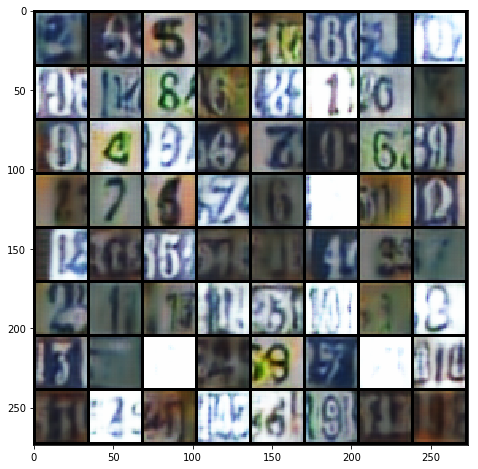

In [64]:
plt.figure(figsize=(8,8))
model.eval()
generator = netG
with torch.no_grad() :
    z_dim = 100
    bs    = 64
    mu    = torch.zeros(bs,z_dim)
    std   = torch.ones(bs,z_dim)
    z     = mu + 1.0 * std * torch.randn_like(std)
    z     = z.to(device)
    gen   = generator(z)
    gen_  = gen.cpu()
    # gen_  = gen_ - gen_.min()
    # gen_  = gen_ / gen_.max()
    # print(gen_.shape)
    # imshow(torchvision.utils.make_grid(gen_))
    grid_img = torchvision.utils.make_grid(gen_.cpu(), nrow=8, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))

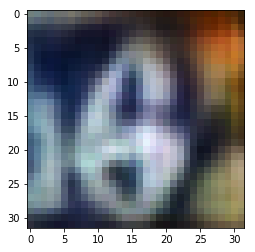

In [65]:
pos1 = (1,3)
pos2 = (3,4)
ind  = 8*(pos1[0]-1) + pos1[1] - 1
ind2 = 8*(pos2[0]-1) + pos2[1] - 1
good_z  = z[ind ].cpu()
good_z2 = z[ind2].cpu()
grid_img = torchvision.utils.make_grid(gen_[ind2].cpu(), nrow=8, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))

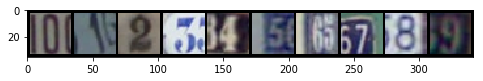

In [34]:
plt.figure(figsize=(8,8))

find_new_examples = False
if find_new_examples :
    found     = torch.zeros(10)
    found_    = 0
    examples_ = torch.empty(10,3,32,32,dtype=torch.float,device='cpu')
    for idx, (data,label) in enumerate(trainset):
        for j in range(label.size(0)):
            l = label[j].item()
            if found[l] == 0:
                found[l] = 1
                found_  += 1
                examples_[l] = data[j,:,:,:]
            else :
                pass
        if found_ == 10 :
            break    
                
find_some_examples = False
if find_some_examples :
    find_again = [9]
    for i in find_again :
        found[i] = 0
        found_  -= 1
    for idx, (data,label) in enumerate(trainset):
        for j in range(label.size(0)):
            l = label[j].item()
            if found[l] == 0:
                found[l] = 1
                found_  += 1
                examples_[l] = data[j,:,:,:]
            else :
                pass
        if found_ == 10 :
            break    

grid_img = torchvision.utils.make_grid(examples_.cpu(), nrow=10, normalize=True)
_ = plt.imshow(grid_img.permute(1, 2, 0))

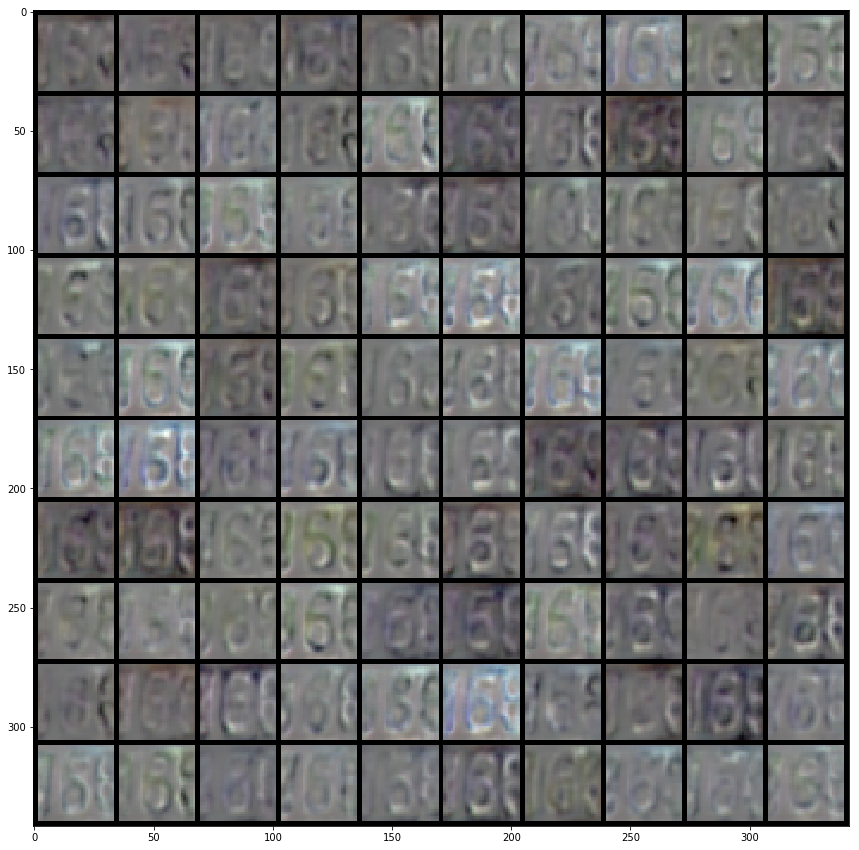

In [45]:
model = netG
plt.figure(figsize=(15,15))
with torch.no_grad():
    eps     = 2
    eps_mat = torch.eye(100) * eps
    eb = good_z.unsqueeze(0)
    # eb      = torch.randn(100).unsqueeze(0)
    # eb      = z[0].cpu().unsqueeze(0)
    e       = eb.repeat(100,1) + eps_mat
    base    = model(eb.to(device))
    out     = model( e.to(device))
    out_diff= out - base.repeat(100,1,1,1)
    # grid_img= torchvision.utils.make_grid(out.cpu(), nrow=10, normalize=True)
    # plt.imshow(grid_img.permute(1, 2, 0))
    
    # out_ = F.interpolate(out, 128, mode='bilinear', align_corners=False)
    # grid_img= torchvision.utils.make_grid(out.cpu(), nrow=10, normalize=True)
    # grid_img= torchvision.utils.make_grid( torch.index_select(out.cpu(),0,picked_dim) , nrow=5, normalize=True)
    grid_img= torchvision.utils.make_grid(out_diff.cpu(), nrow=10, normalize=True)
    
    plt.imshow(grid_img.permute(1, 2, 0))

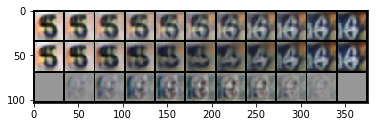

In [66]:
def lazy_interpolation(model,z):
    alpha = torch.linspace(0, 1, steps=11)
    alpha = torch.transpose(alpha.repeat(1,3,32,32,1),0,-1).squeeze(-1)
    alpha = alpha.to(device)
    g = model(z)
    g = g[0].unsqueeze(0).repeat(11,1,1,1)*(1-alpha) + g[1].unsqueeze(0).repeat(11,1,1,1)*alpha
    return g
    
def latent_interpolation(model,z):
    alpha = torch.linspace(0, 1, steps=11)
    alpha = torch.transpose(alpha.repeat(100,1),0,-1)
    alpha = alpha.to(device)
    z = z[0].unsqueeze(0).repeat(11,1)*(1-alpha) + z[1].unsqueeze(0).repeat(11,1)*alpha
    g = model(z)
    return g

z_dim = 100
model = netG
_ = model.to(device)
model.eval()
with torch.no_grad() :
    z_dim = 100
    bs    = 2
    mu    = torch.zeros(bs,z_dim)
    std   = torch.ones(bs,z_dim)
    # z     = torch.randn(bs,z_dim,device=device)
    z     = torch.cat((good_z.unsqueeze(0),good_z2.unsqueeze(0)),dim=0).to(device)
    lz_interpol = lazy_interpolation(model,z).cpu()
    lt_interpol = latent_interpolation(model,z).cpu()
    
    disp     = torch.cat((lz_interpol,lt_interpol,lt_interpol-lz_interpol),dim=0)
    grid_img = torchvision.utils.make_grid(disp.cpu(), nrow=11, normalize=True)
    _ = plt.imshow(grid_img.permute(1, 2, 0))
    
    # imshow(torchvision.utils.make_grid(lz_interpol))
    # imshow(torchvision.utils.make_grid(lt_interpol))
    # diff between the 2 interpol
    # imshow(torchvision.utils.make_grid(lt_interpol-lz_interpol))

# Quantitative evaluation

#### Sample 1000 images from the true prior for each model and put the results in a directory

In [67]:
def save_sample_to_dir(i,sample,dir_):
    # assuming :
    #            sample is 3x32x32
    #            dir_ exists
    # save sample as "i.jpg"
    save_image(sample.cpu(), dir_ + "\{num}.jpg".format(num=i) , normalize=True )   

def generate_samples_and_save_to_dir(model,bn,bs,dir_):
    # assuming the prior is std normal in 100 dim
    # generate bs samples from model and save them to dir
    # numbered from bn to bn + bs
    # where bn : batch number
    #       bs : batch size
    e   = torch.randn(bs,100,device=device)
    gen = model(e)
    for i in range(bs):
        save_sample_to_dir(bn*bs+i,gen[i],dir_)

In [76]:
#### TODO
samples_dir = "sample_directory\GAN\samples"
n_samples  = 1000
batch_size = 100
n_batches  = 10
for i in range(n_batches) :
    generate_samples_and_save_to_dir(netG,i,batch_size,samples_dir)